In [2]:
## Importing necessary libraries ##
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoLarsCV, RidgeCV, ElasticNetCV, BayesianRidge, ARDRegression, SGDRegressor, LogisticRegressionCV
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Reading the Data

In [3]:
train = pd.read_csv('train_auto.csv')
test = pd.read_csv('test_auto.csv')
test_Y = pd.read_csv('SHELL_AUTO.csv')

In [4]:
train_y = train['TARGET_FLAG']
train_y1 = train['TARGET_AMT']
test_y = test_Y['p_target']

In [5]:
train = train.drop(columns = ['TARGET_FLAG','TARGET_AMT'])
test = test.drop(columns=['TARGET_FLAG','TARGET_AMT'])

In [6]:
train_y.value_counts()

0    6008
1    2153
Name: TARGET_FLAG, dtype: int64

In [7]:
train_y1.describe()

count      8161.000000
mean       1504.324648
std        4704.026930
min           0.000000
25%           0.000000
50%           0.000000
75%        1036.000000
max      107586.136160
Name: TARGET_AMT, dtype: float64

In [8]:
def error(actual, predicted):
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

In [9]:
val_col = ['AGE', 'YOJ', 'CAR_AGE', 'INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']

for i in val_col:
    train[i]=train[i].fillna(0).values
    train[i] = train[i].replace('[\$,]', '', regex=True).astype(float)
    
train['JOB'] = train['JOB'].fillna('Null').values

In [10]:
val_col = ['AGE', 'YOJ', 'CAR_AGE', 'INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']

for i in val_col:
    test[i] = test[i].fillna(0).values
    test[i] = test[i].replace('[\$,]', '', regex=True).astype(float)
    
test['JOB'] = test['JOB'].fillna('Null').values

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in test.columns:
    if test[column_name].dtype == object:
        print(column_name)
        test[column_name] = le.fit_transform(test[column_name].values)
    else:
        pass

PARENT1
MSTATUS
SEX
EDUCATION
JOB
CAR_USE
CAR_TYPE
RED_CAR
REVOKED
URBANICITY


In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in train.columns:
    if train[column_name].dtype == object:
        print(column_name)
        train[column_name] = le.fit_transform(train[column_name].values)
    else:
        pass

PARENT1
MSTATUS
SEX
EDUCATION
JOB
CAR_USE
CAR_TYPE
RED_CAR
REVOKED
URBANICITY


In [13]:
train.dtypes

INDEX           int64
KIDSDRIV        int64
AGE           float64
HOMEKIDS        int64
YOJ           float64
INCOME        float64
PARENT1         int64
HOME_VAL      float64
MSTATUS         int64
SEX             int64
EDUCATION       int64
JOB             int64
TRAVTIME        int64
CAR_USE         int64
BLUEBOOK      float64
TIF             int64
CAR_TYPE        int64
RED_CAR         int64
OLDCLAIM      float64
CLM_FREQ        int64
REVOKED         int64
MVR_PTS         int64
CAR_AGE       float64
URBANICITY      int64
dtype: object

# Regression Models

## Linear Regression

In [37]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(train,train_y1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
Ypred = lm.predict(test)

In [39]:
error(test_y, Ypred)

1608.9585813111332

In [40]:
pred = pd.DataFrame()
pred['INDEX'] = test['INDEX']
pred['TARGET_AMT'] = pd.Series(Ypred)
pred = pred.set_index('INDEX')

In [41]:
## If the amount is greater than 0, then Flag is 1
pred.loc[pred['TARGET_AMT'] > 0, 'TARGET_FLAG'] = 1
pred.loc[pred['TARGET_AMT'] <= 0, 'TARGET_FLAG'] = 0

In [42]:
pred.to_csv('linear_reg.csv', index=True)

## XGBoost Regression

In [21]:
import xgboost as xgb
xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(train,train_y1)
Ypred = xgbr.predict(test)

In [44]:
error(test_y, Ypred)

2631.4780231742657

In [45]:
pred = pd.DataFrame()
pred['INDEX'] = test['INDEX']
pred['TARGET_AMT'] = pd.Series(Ypred)
pred = pred.set_index('INDEX')

pred.loc[pred['TARGET_AMT'] > 0, 'TARGET_FLAG'] = 1
pred.loc[pred['TARGET_AMT'] <= 0, 'TARGET_FLAG'] = 0

pred.to_csv('xbg_reg.csv', index=True)

## Random Forest Regression

In [46]:
forest = RandomForestRegressor(n_estimators=3000, random_state=42)
forest.fit(train,train_y1)
Ypred = forest.predict(test)

In [47]:
error(test_y, Ypred)

2332.36389561242

In [48]:
pred = pd.DataFrame()
pred['INDEX'] = test['INDEX']
pred['TARGET_AMT'] = pd.Series(Ypred)
pred = pred.set_index('INDEX')

pred.loc[pred['TARGET_AMT'] > 0, 'TARGET_FLAG'] = 1
pred.loc[pred['TARGET_AMT'] <= 0, 'TARGET_FLAG'] = 0

pred.to_csv('rf_reg.csv', index=True)

In [51]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('MLP', MLPRegressor(max_iter = 500)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
for name, model in models:
    model.fit(train, train_y1)
    y = model.predict(test)
    print(name + " : " + str(mean_squared_error(test_y, y,squared=False)))

LR : 1608.9585813111332
LASSO : 1606.2270391145114
MLP : 1092.3373328436373
KNN : 2357.738858609399
DecisionTree : 5279.924960568266
SVR : 345.0493816758177


In [14]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

model = Sequential()
model.add(Dense(24, input_dim=24, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 200       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [16]:
history = model.fit(train, train_y1, epochs=150, batch_size=50, verbose=1)

Epoch 1/150
164/164 [==============================] - 0s 811us/step - loss: 23531354.0000 - mse: 23531354.0000 - mae: 2235.2588
Epoch 2/150
164/164 [==============================] - 0s 604us/step - loss: 22286842.0000 - mse: 22286842.0000 - mae: 2138.1382
Epoch 3/150
164/164 [==============================] - 0s 717us/step - loss: 22283138.0000 - mse: 22283138.0000 - mae: 2128.3083
Epoch 4/150
164/164 [==============================] - 0s 606us/step - loss: 22396252.0000 - mse: 22396252.0000 - mae: 2142.9858
Epoch 5/150
164/164 [==============================] - 0s 598us/step - loss: 22274674.0000 - mse: 22274674.0000 - mae: 2129.4114
Epoch 6/150
164/164 [==============================] - 0s 695us/step - loss: 22254248.0000 - mse: 22254248.0000 - mae: 2113.4216
Epoch 7/150
164/164 [==============================] - 0s 596us/step - loss: 22157934.0000 - mse: 22157934.0000 - mae: 2115.2524
Epoch 8/150
164/164 [==============================] - 0s 606us/step - loss: 22178842.0000 - mse:

164/164 [==============================] - 0s 592us/step - loss: 21804214.0000 - mse: 21804214.0000 - mae: 2083.9131
Epoch 65/150
164/164 [==============================] - 0s 564us/step - loss: 21766906.0000 - mse: 21766906.0000 - mae: 2065.4058
Epoch 66/150
164/164 [==============================] - 0s 574us/step - loss: 21837896.0000 - mse: 21837896.0000 - mae: 2084.1868
Epoch 67/150
164/164 [==============================] - 0s 579us/step - loss: 21825472.0000 - mse: 21825472.0000 - mae: 2083.6331
Epoch 68/150
164/164 [==============================] - 0s 576us/step - loss: 21754544.0000 - mse: 21754544.0000 - mae: 2063.1223
Epoch 69/150
164/164 [==============================] - 0s 568us/step - loss: 21798858.0000 - mse: 21798858.0000 - mae: 2104.2224
Epoch 70/150
164/164 [==============================] - 0s 576us/step - loss: 21793876.0000 - mse: 21793876.0000 - mae: 2064.4722
Epoch 71/150
164/164 [==============================] - 0s 618us/step - loss: 21786582.0000 - mse: 2178

164/164 [==============================] - 0s 623us/step - loss: 21653324.0000 - mse: 21653324.0000 - mae: 2074.6580
Epoch 127/150
164/164 [==============================] - 0s 610us/step - loss: 21730684.0000 - mse: 21730684.0000 - mae: 2079.9165
Epoch 128/150
164/164 [==============================] - 0s 608us/step - loss: 21650124.0000 - mse: 21650124.0000 - mae: 2070.1997
Epoch 129/150
164/164 [==============================] - 0s 598us/step - loss: 21668490.0000 - mse: 21668492.0000 - mae: 2086.2222
Epoch 130/150
164/164 [==============================] - 0s 612us/step - loss: 21639518.0000 - mse: 21639518.0000 - mae: 2069.8679
Epoch 131/150
164/164 [==============================] - 0s 600us/step - loss: 21658182.0000 - mse: 21658182.0000 - mae: 2087.9399
Epoch 132/150
164/164 [==============================] - 0s 618us/step - loss: 21648818.0000 - mse: 21648818.0000 - mae: 2081.3435
Epoch 133/150
164/164 [==============================] - 0s 602us/step - loss: 21633978.0000 - ms

dict_keys(['loss', 'mse', 'mae'])


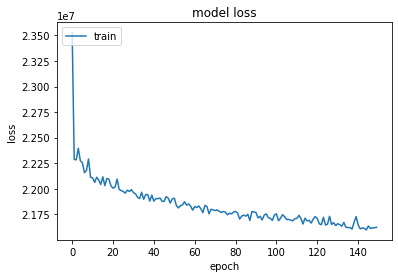

In [17]:
import matplotlib.pyplot as plt
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [24]:
Ypred = model.predict(test)

In [25]:
Ypred

array([[2281.582  ],
       [2763.805  ],
       [ 322.1449 ],
       ...,
       [ 380.19476],
       [3625.948  ],
       [ 968.3492 ]], dtype=float32)

#### Support Vector regression and Multi-layer Perceptron regressor performed significantly better than the baseline linear algorithms (linear regression and Lasso). This is possible due to their ability to account for nonlinear interactions between the predictor variables and the severity loss!
